# The Little Pascals: Project 2 Calculator

## Part A
Determine the Power Req'd for A, B,& C (min and max values plugged into Matlab Oilflow Code)

Power requirements for typical fleet, 'sans  drag force' to tack on: **412 hp**
    
Number of trucks: **7500**


1. Use the drag data to determine drag coefficient

$C_{form} = \frac{F_{D}}{1/2 \rho U^2 A}$ 
    
    Convert drag force into lbm since coefficient equation uses density

    Find the average drag coefficient for each of the models.
    
2. Find average drag force for each of the different models based on average drag coefficient and average density

$F_{D} = C_{D} 1/2 \rho u^2 A$

3. Use this to find power loss (add to the initial 412)

    Using the average drag coefficient, average velocity, average density find drag and then power loss
    
    The design velocity would be the max and min velocity recorded for worst case scenario

$P = F_{D} V_{design}$   
    
3. Plug into Matlab code to determine optimal oil flow in pipes

### Part A code
#### Reading the file names and converting units 
To edit the following code to use another file all that would need to be edited is the file name as the filepath.

If the file name remainds the same as provided, no need to change.
The units are from mph to ft/s and lbf to lbm.

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

g = 32.2
 
def readcsv_drag(filepath, columnname): #function to read the drag csv file 
    model = pd.read_csv(filepath)
    model = model[["Wind Speed [mph]","Temperature [F]","Drag Force [lbf]"]] #separating column by title 
    return np.array(model[columnname]) #return selected column as an array 
                                
ua = readcsv_drag("Data/windtunnel/modelA.csv","Wind Speed [mph]") #u velocity array
ta = readcsv_drag("Data/windtunnel/modelA.csv","Temperature [F]")  #t temperature 
da = readcsv_drag("Data/windtunnel/modelA.csv","Drag Force [lbf]") #d drag force

ub = readcsv_drag("Data/windtunnel/modelB.csv","Wind Speed [mph]")
tb = readcsv_drag("Data/windtunnel/modelB.csv","Temperature [F]")
db = readcsv_drag("Data/windtunnel/modelB.csv","Drag Force [lbf]")

uc = readcsv_drag("Data/windtunnel/modelC.csv","Wind Speed [mph]")
tc = readcsv_drag("Data/windtunnel/modelC.csv","Temperature [F]")
dc = readcsv_drag("Data/windtunnel/modelC.csv","Drag Force [lbf]")

mod = pd.read_json (r'Data/models.json') #read json file
mod = mod[["name","width","height","length"]] #separate columns by title
SA = np.array(mod) #create array with surface area info


#Convert functions for correct units
def convert_V(u):
    return u*1.46667 #converts from mph to ft/s 

ua = convert_V(ua)   #applies function to the different model velocities
ub = convert_V(ub)
uc = convert_V(uc)

def convert_D(d): 
    return d/g       #converts drag from lbf to lbm for density calculations

da = convert_D(da)
db = convert_D(db)
dc = convert_D(dc)

#Find surface area of each model width*height as "a_"
aA = SA[0,1]*SA[0,2]/12
aB = SA[1,1]*SA[1,2]/12
aC = SA[2,1]*SA[2,2]/12

In [2]:
#from text, temperature and related density arrays for air
t = np.array([0,10,20,30,40,50,60,70,80,90,100])
rho = np.array([2.683e-3,2.626e-3,2.571e-3,2.519e-3,2.469e-3,2.420e-3,2.373e-3, 2.329e-3,2.286e-3,2.244e-3,2.204e-3])

denA = [] #empty arrays to fill for the densities of the air from given temp
denB = []
denC = []
    
def temp_den(temp): #finds appropriate density for measured air temperature 
    global denA, denB, denC #these variables can be called and changed outside of the funciton
    for item in temp:
        if item == any(t): #if any temperature is equal to an even temperature
            position = np.where(item == any(t)) #find its index
            density = rho[position[0]] #set density to matching values
            
        else: #if not an even temp
            density = np.interp(item,t,rho) #interpolate between the two arrays for the given value
            
        if all(temp == ta): 
            denA.append(density) #adds the density to the appropriate array depending on the variable
            
        elif all(temp == tb): 
            denB.append(density)
            
        else: 
            denC.append(density)

#density arrays as "den_"
temp_den(ta)
temp_den(tb)  
temp_den(tc)

def dragcof(d,u,den,a): #find drag coefficient with drag, velocity, density and area
    den = np.array(den)
    return d*2*g/(.5*a*den*u**2)

ca = dragcof(da,ua,denA,aA) #find drag coefficiens for the three models
cb = dragcof(db,ub,denB,aB)
cc = dragcof(dc,uc,denC,aC)

In [3]:
def av(input):
    return np.mean(input) #find average of input

#position in the array:
#           0   1   2   3   4    5   6     7    8
mod_val = [ua, ub, uc, ca, cb, cc, denA, denB, denC]
av_val = np.array(list(map(av, mod_val))) #apply average function to each item in mod_val list, create an array

#Determine drag force from average values above (in lbf)

# 1/2* Area * Velocity^2 * Drag Coefficient * Density
fdA = .5*aA*(av_val[0]**2)*av_val[3]*av_val[6] #using the labeled index for the values above
fdB = .5*aB*(av_val[1]**2)*av_val[4]*av_val[7]
fdC = .5*aC*(av_val[2]**2)*av_val[5]*av_val[8]

#Powerloss: to determine min and max values of trucks to plug into matlab (in hp)
def pmax(v,f):
    V = np.max(v)
    return ((f*V)/550) + 412 #convert to hp and add the general hp requirement for trucks given

def pmin(v,f):
    V = np.min(v)
    return ((f*V)/550) + 412

print(f"The estimated power requirements for each truck are \n\
Model A \n max : {round(pmax(ua,fdA),5)}, min : {round(pmin(ua,fdA),5)} hp \n\
Model B \n max : {round(pmax(ub,fdB),5)}, min : {round(pmin(ub,fdB),5)} hp \n\
Model C \n max : {round(pmax(uc,fdC),5)}, min : {round(pmin(uc,fdC),5)} hp")

The estimated power requirements for each truck are 
Model A 
 max : 430.80383, min : 418.26794 hp 
Model B 
 max : 423.26292, min : 415.75431 hp 
Model C 
 max : 434.68209, min : 419.5607 hp


#### Output from the Matlab code provided: 
Model A: $Q_{R}(\mathcal{P}_{min}, \mathcal{P}_{max}) = 201.57 \frac{L}{hr}$

Model B: $Q_{R}(\mathcal{P}_{min}, \mathcal{P}_{max}) = 201.50 \frac{L}{hr}$ 

Model C: $Q_{R}(\mathcal{P}_{min}, \mathcal{P}_{max}) = 201.54 \frac{L}{hr}$

*Note: for model B the difference between power min and max was too small for the matlab program, but decreasing it by 2 hp produced a difference of .04 from the other optimal flow rates.

In [4]:
#optimal flow rates from power requirements converted to ft^3/s
Qr_A = (0.0353147/(3600))*201.57
Qr_B = (0.0353147/(3600))*201.5
Qr_C = (0.0353147/(3600))*201.54
print(f"Qr (optimal oil flow rate from power requirements) for \nModel A: {Qr_A}\nModel B: {Qr_B}\nModel C: {Qr_C}")

Qr (optimal oil flow rate from power requirements) for 
Model A: 0.0019773289108333332
Model B: 0.001976642236111111
Model C: 0.0019770346216666664


## Part B

1. Pump Performance Curves:

    $h_{a} = \frac{\Delta P}{\rho g}$ 
    

2. System Curves:

    $h_{sys} = dz + KQ^2$

   Assumption - the change in z is negligible compared to the head from the system

   Use systems file for oil to engine (delivery) losses with various bends and lengths 
    
   (combination of minor and major losses) and the additional k value for various pumps to compare

### Delivery System

In [5]:
#For Delivery sys length
import json
from pandas import json_normalize
import sys 
sys=open('data/system.json')
DevJ=json.load(sys)
Dev=pd.json_normalize(DevJ['Delivery'])
Len12=Dev[["Lengths.12in"]]
Len36=Dev[["Lengths.36in"]]
Len86=Dev[["Lengths.86in"]]
Len300=Dev[["Lengths.300in"]]
len12=Len12.to_numpy()
len36=Len36.to_numpy()
len86=Len86.to_numpy()
len300=Len300.to_numpy()
lentot=len12+36/12*len36+86/12*len86+300/12*len300
print(lentot,"ft")

[[164.]] ft


In [6]:
#K for Delivery sys comp
Comp180=Dev[["Components.180 deg bend, threaded"]]
Comp90=Dev[["Components.90 deg bend, threaded"]]
CompU=Dev[["Components.Union, threaded"]]
comp180=Comp180.to_numpy()
comp90=Comp90.to_numpy()
compu=CompU.to_numpy()
kcomp=1.5*comp180+1.5*comp90+.08*compu
print(kcomp,"ft")

[[42.76]] ft


In [7]:
#For Filter sys length
Fil=pd.json_normalize(DevJ['Filter'])
FilLen12=Fil[["Lengths.12in"]]
FilLen36=Fil[["Lengths.36in"]]
FilLen86=Fil[["Lengths.86in"]]
FilLen300=Fil[["Lengths.300in"]]
fillen12=FilLen12.to_numpy()
fillen36=FilLen36.to_numpy()
fillen86=FilLen86.to_numpy()
fillen300=FilLen300.to_numpy()
fillentot=fillen12+36/12*fillen36+86/12*fillen86+300/12*fillen300
print(fillentot,"ft")

[[104.83333333]] ft


In [8]:
#K for Filter sys comp
FilComp180=Fil[["Components.180 deg bend, flanged"]]
FilComp90=Fil[["Components.90 deg bend, flanged"]]
FilComp45=Fil[["Components.45 deg bend flanged"]]
FilCompu=Fil[["Components.Union, threaded"]]
filcomp180=FilComp180.to_numpy()
filcomp90=FilComp90.to_numpy()
filcomp45=FilComp45.to_numpy()
filcompu=FilCompu.to_numpy()
filkcomp=.2*filcomp180+.3*filcomp90+.2*filcomp45+.08*filcompu
print(filkcomp,"ft")

# K for each filter system
filt = open('data/filters.json')
Filt = json.load(filt)

def filtprop(num):
    fil = pd.json_normalize(Filt[num])
    price = np.array(fil[['price']])
    k = np.array(fil[['K']])
    ef = np.array(fil[['efficiency']])
    return np.array([price,ef,k])


#filter 1 
filt1 = filtprop('1')
pr1 = filt1[0]
ef1 = filt1[1]
k1 = filt1[2]
ktot1 = filkcomp + k1

#filter 2
filt2 = filtprop('2')
pr2 = filt2[0]
ef2 = filt2[1]
k2 = filt2[2]
ktot2 = filkcomp + k2

#filter 3 
filt3 = filtprop('3')
pr3 = filt3[0]
ef3 = filt3[1]
k3 = filt3[2]
ktot3 = filkcomp + k3

#filter 4 
filt4 = filtprop('4')
pr4 = filt4[0]
ef4 = filt4[1]
k4 = filt4[2]
ktot4 = filkcomp + k4

#filter 5
filt5 = filtprop('5')
pr5 = filt5[0]
ef5 = filt5[1]
k5 = filt5[2]
ktot5 = filkcomp + k5

[[8.8]] ft


In [9]:
def labelP():
    plt.xlabel("Q (ft^3/s)")
    plt.ylabel("h (ft)")
    
def labelN():
    plt.xlabel("Q (ft^3/s)")
    plt.ylabel("Efficiency (%)")

### VOLVO Pump

In [10]:
import matplotlib.pyplot as plt
#Read files
Volv=pd.read_csv("Data/pumps/VOLVO-D13.csv")
Pai=pd.read_csv("Data/pumps/PAI-DT466.csv")
Cumin=pd.read_csv("Data/pumps/CUMINS-M11.csv")
dens = 1.77 #slugs per ft cubed. oil? table 1.5 page 814

(0.002530886833333333, 1.6216103820139667)

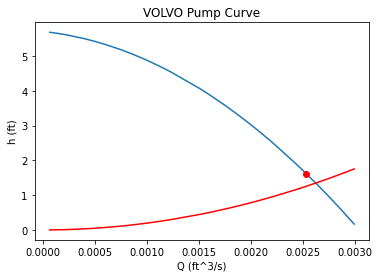

In [11]:
#For Volv pump curve
Volvpc=Volv[["flowrate [L/h]","pressure drop [kPa]"]]
## Sorts Values
Volvcur=Volvpc.sort_values(by='flowrate [L/h]')
VolvdP=Volvcur[['pressure drop [kPa]']]
VolvdP=VolvdP*(20.89/(1.74*32.2**2))
## Converts units
VolvQ=(0.0353147/3600)*Volvcur[["flowrate [L/h]"]]
VolvDp=VolvdP.to_numpy().astype('float').flatten()
Volvq=VolvQ.to_numpy().astype('float').flatten()

## Curve fit
Volvfit=np.polyfit(Volvq,VolvDp,2)
Volvp=np.poly1d(Volvfit)
plt.plot(Volvq,Volvp(Volvq),'-')

# Volv Del sys curve
VolvDevA=Dev[["Diameters"]].replace('in','',regex=True)
VolvDeva=VolvDevA.replace('/',' ',regex=True)
VolvDevAa=VolvDeva['Diameters'].astype('|S')
VolvDevaa=VolvDevAa.astype('str')
VolvDevAA=VolvDevaa.str.split(" ", 1,expand=True)
VolvDevDia=VolvDevAA.to_numpy().flatten()
VolvdevDia=pd.DataFrame(VolvDevDia)
VolvdevDiafix=VolvdevDia.replace('b','', regex=True)
VolvdevDiaFix=VolvdevDiafix.replace("'",'',regex=True).astype('int')
Volvdevdiafix=VolvdevDiaFix.to_numpy()
Volvdevdia=Volvdevdiafix[0]/Volvdevdiafix[1]
Volvdevdia=Volvdevdia.astype('float')
devsysvel=Volvq/(.25*3.14*Volvdevdia**2)
# Re for Volv Del sys
nu=4.5*10**-3
VolvRe=Volvdevdia*devsysvel/nu
VolvRe=VolvRe.astype('float')
# e for del
VolvDevE=Dev[["Material"]].replace('Plastic/Polymer','0',regex=True)
VolvDeve=VolvDevE.to_numpy().astype('int')
# f for del
f=np.choose(VolvRe<2000,[
    (1/(-1.8*np.log10((6.9/VolvRe))))**2,
                      64/VolvRe])
fi=np.sum([f])
# ktot
Leqm=kcomp*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+lentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
VPC_x = Volvq[find].astype('float')
VPC_y = Volvfind[find].astype('float')
labelP()
plt.title("VOLVO Pump Curve")
VPC_x[0], VPC_y[0]

(0.002432790444444444, 75.4329881246153)

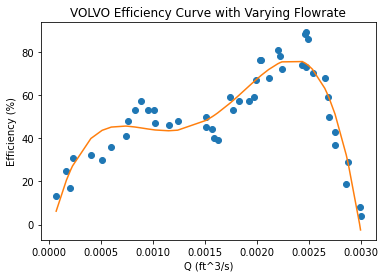

In [12]:
# Volvo Efficiency 
EFF=Volv[['flowrate [L/h]','efficiency [%]']]
EFf=EFF.replace('%','',regex=True)
Ef=EFf.sort_values(by='flowrate [L/h]')
Q=.0353147/3600*Ef[['flowrate [L/h]']]
eF=Ef[['efficiency [%]']]
q=Q.to_numpy().astype('float').flatten()
ef=eF.to_numpy().astype('float').flatten()
ef=eF.to_numpy().astype('float')
Volvefffit=np.polyfit(q,ef,4).flatten()
Volveffp=np.poly1d(Volvefffit)
plt.plot(q,ef,'o',q,Volveffp(q),'-')
VolvBEP = np.max(Volveffp(q))
VolvBEP
VolvX = np.argmax(Volveffp(q))
plt.title("VOLVO Efficiency Curve with Varying Flowrate")
labelN()
q[VolvX],VolvBEP

### PAI Pump

(0.0026878410555555552, 2.0193703356192394)

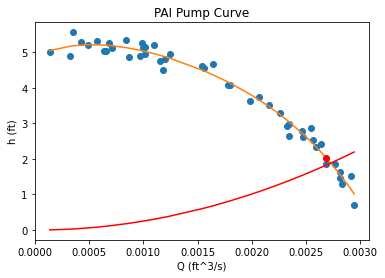

In [13]:
#For pai pump curve
Paipc=Pai[["flowrate [L/h]","pressure drop [kPa]"]]
## Sorts Values
Paicur=Paipc.sort_values(by='flowrate [L/h]')
PaidP=Paicur[['pressure drop [kPa]']]
PaidP=(20.89/(1.74*32.2**2))*PaidP
## Converts units
PaiQ=.0353147/3600*Paicur[["flowrate [L/h]"]]
PaiDp=PaidP.to_numpy().astype('float').flatten()
Paiq=PaiQ.to_numpy().astype('float').flatten()
plt.plot(Paiq,PaiDp,'o')

##Curve fit
Paifit=np.polyfit(Paiq,PaiDp,4).flatten()
Paip=np.poly1d(Paifit)
plt.plot(Paiq,Paip(Paiq),'-')

#Pai Del sys curve
PaiDevA=Dev[["Diameters"]].replace('in','',regex=True)
PaiDeva=PaiDevA.replace('/',' ',regex=True)
PaiDevAa=PaiDeva['Diameters'].astype('|S')
PaiDevaa=PaiDevAa.astype('str')
PaiDevAA=PaiDevaa.str.split(" ", 1,expand=True)
PaiDevDia=PaiDevAA.to_numpy().flatten()
PaidevDia=pd.DataFrame(PaiDevDia)
PaidevDiafix=PaidevDia.replace('b','', regex=True)
PaidevDiaFix=PaidevDiafix.replace("'",'',regex=True).astype('int')
Paidevdiafix=PaidevDiaFix.to_numpy()
Paidevdia=Paidevdiafix[0]/Paidevdiafix[1]
Paidevsysvel=Paiq/Paidevdia

#Re for Volv Del sys
nu=4.5*10**-3
PaiRe=Paidevdia*Paidevsysvel/nu
PaiRe
#e for del
PaiDevE=Dev[["Material"]].replace('Plastic/Polymer','0',regex=True)
PaiDeve=PaiDevE.to_numpy().astype('int')
# f for del
f=np.choose(PaiRe<2000,[
    (1/(-1.8*np.log10((6.9/PaiRe))))**2,
                      64/PaiRe])
fi=np.sum([f])
# ktot
Leqm=kcomp*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+lentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]

PSC_x = Paiq[find].astype(np.float)
PSC_y = Paifind[find].astype(np.float)
plt.title("PAI Pump Curve")
labelP()
PSC_x[0], PSC_y[0]

(0.0017951639166666664, 79.02538551042181)

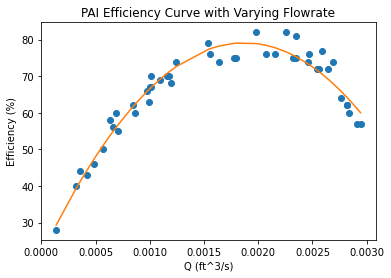

In [14]:
# Pai Efficiency 
PaiEFF=Pai[['flowrate [L/h]','efficiency  [%]']]
PaiEFf=PaiEFF.replace('%','',regex=True)
PaiEf=PaiEFf.sort_values(by='flowrate [L/h]')
PaiQe=.0353147*3600*PaiEf[['flowrate [L/h]']]
PaieF=PaiEf[['efficiency  [%]']]
Paiqe=PaiQ.to_numpy().astype('float').flatten()
Paief=PaieF.to_numpy().astype('float').flatten()
Paiefffit=np.polyfit(Paiqe,Paief,2).flatten()
Paieffp=np.poly1d(Paiefffit)
plt.plot(Paiqe,Paief,'o',Paiqe,Paieffp(Paiqe),'-')
PaiBEP = np.max(Paieffp(Paiqe))
plt.title("PAI Efficiency Curve with Varying Flowrate")
labelN()
PaiX = np.argmax(Paieffp(Paiqe))
Paiqe[PaiX],PaiBEP

### CUMIN Pump

(0.002727079611111111, 0.002727079611111111)

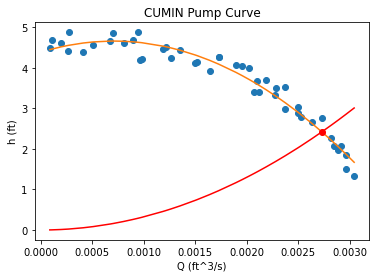

In [15]:
#For Cumin pump curve
Cuminpc=Cumin[["flowrate [L/h]","pressure drop [kPa]"]]
## Sorts Values
Cumincur=Cuminpc.sort_values(by='flowrate [L/h]')
CumindP=Cumincur[['pressure drop [kPa]']]*(20.89/(1.74*32.2**2))
## Converts units
CuminQ=.0353147/3600*Cumincur[["flowrate [L/h]"]]
CuminDp=CumindP.to_numpy().astype('float').flatten()
Cuminq=CuminQ.to_numpy().astype('float').flatten()
plt.plot(Cuminq,CuminDp,'o')
##Curve fit
Cuminfit=np.polyfit(Cuminq,CuminDp,2).flatten()
Cuminp=np.poly1d(Cuminfit)
plt.plot(Cuminq,Cuminp(Cuminq),'-')
#Pai Del sys curve
CuminDevA=Dev[["Diameters"]].replace('in','',regex=True)
CuminDeva=CuminDevA.replace('/',' ',regex=True)
CuminDevAa=CuminDeva['Diameters'].astype('|S')
CuminDevaa=CuminDevAa.astype('str')
CuminDevAA=CuminDevaa.str.split(" ", 1,expand=True)
CuminDevDia=CuminDevAA.to_numpy().flatten()
CumindevDia=pd.DataFrame(CuminDevDia)
CumindevDiafix=CumindevDia.replace('b','', regex=True)
CumindevDiaFix=CumindevDiafix.replace("'",'',regex=True).astype('int')
Cumindevdiafix=CumindevDiaFix.to_numpy()
Cumindevdia=Cumindevdiafix[0]/Cumindevdiafix[1]
Cumindevsysvel=Cuminq/Cumindevdia
#Re for Volv Del sys
nu=4.5*10**-3
CuminRe=Cumindevdia*Cumindevsysvel/nu
#e for del
CuminDevE=Dev[["Material"]].replace('Plastic/Polymer','0',regex=True)
CuminDeve=CuminDevE.to_numpy().astype('float')
# f for del
f=np.choose(CuminRe<2000,[
    (1/(-1.8*np.log10((6.9/CuminRe))))**2,
                      64/CuminRe])
fi=np.sum([f])
# ktot
Leqm=kcomp*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+lentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]
labelP()
plt.title("CUMIN Pump Curve")
CPC_x = Cuminq[find].astype(np.float)
CPC_y = Cuminq[find].astype(np.float)
CPC_x[0], CPC_y[0]

0.0015204940277777775 73.43778034089814


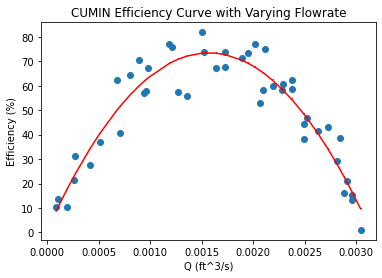

In [16]:
# Cumin Efficiency 
CuminEFF=Cumin[['flowrate [L/h]','efficiency [%]']]
CuminEFf=CuminEFF.replace('%','',regex=True)
CuminEFf=CuminEFf.astype('float')
CuminEFf=CuminEFf.astype('float')
CuminEf=CuminEFf.sort_values(by='flowrate [L/h]')
CuminQe=.0353147/3600*CuminEf[['flowrate [L/h]']]
CumineF=CuminEf[['efficiency [%]']]
CumineeF=CumineF.astype(int)
Cuminqe=CuminQe.to_numpy().astype('float').flatten()
Cuminef=CumineF.to_numpy().astype('float').flatten()
Cuminefffit=np.polyfit(Cuminqe,Cuminef,2).flatten()
Cumineffp=np.poly1d(Cuminefffit)
plt.plot(Cuminqe,Cuminef,'o',Cuminqe,Cumineffp(Cuminqe),'r,-')
CuminBEP = np.max(Cumineffp(Cuminqe))
CuminBEP
plt.title("CUMIN Efficiency Curve with Varying Flowrate")
labelN()
Cx = np.argmax(Cumineffp(Cuminqe))
print(Cuminqe[Cx],CuminBEP)

### Filter 1 

(0.002530886833333333, 1.6216103820139667)

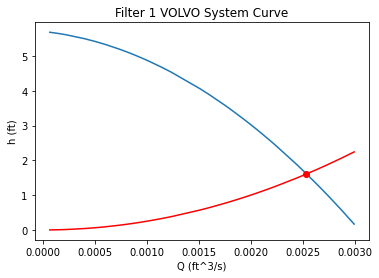

In [17]:
# first Volv filter sys curve
plt.plot(Volvq,Volvp(Volvq),'-')
Leqm=ktot1*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
Volvq[find]
plt.title("Filter 1 VOLVO System Curve")
labelP()
VFC_x = Volvq[find].astype(np.float)
VFC_y = Volvfind[find].astype(np.float)
VFC_x[0], VFC_y[0]

(0.0026878410555555552, 2.0193703356192394)

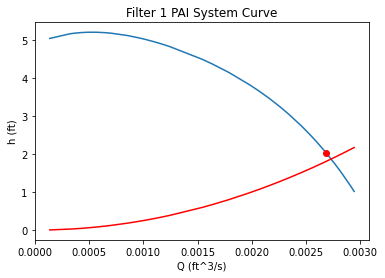

In [18]:
# first Pai filter sys curve
plt.plot(Paiq,Paip(Paiq),'-')
Leqm=ktot1*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]
plt.title("Filter 1 PAI System Curve")
labelP()
PFC_x = Paiq[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
PFC_x[0], PFC_y[0]

(0.0028447952777777776, 0.0028447952777777776)

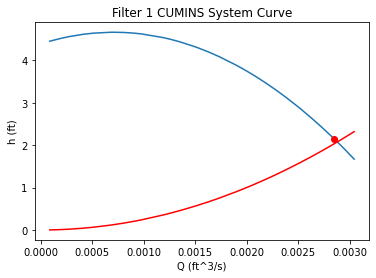

In [19]:
# first Cumins filter sys curve
plt.plot(Cuminq,Cuminp(Cuminq),'-')
Leqm=ktot1*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]
CFC1_x = Cuminq[find].astype(np.float)
CFC1_y = Cuminq[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 1 CUMINS System Curve")
labelP()
CFC1_x[0], CFC1_y[0]

### Filter 2

(0.0024720289999999997, 1.791491921251486)

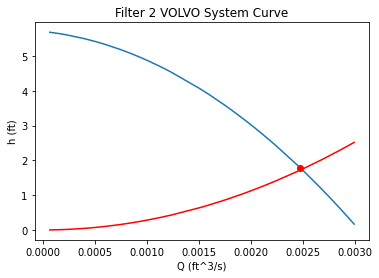

In [20]:
# second Volv filter sys curve
plt.plot(Volvq,Volvp(Volvq),'-')
Leqm=ktot2*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
Volvq[find]
VFC2_x = Volvq[find].astype(np.float)
VFC2_y = Volvfind[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 2 VOLVO System Curve")
labelP()
VFC2_x[0], VFC2_y[0]

(0.002638792861111111, 2.1855941190714856)

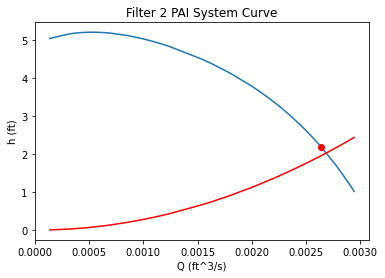

In [21]:
# second Pai filter sys curve
plt.plot(Paiq,Paip(Paiq),'-')
Leqm=ktot2*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]

PFC2_x = Paiq[find].astype(np.float)
PFC2_y = Paifind[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 2 PAI System Curve")
labelP()
PFC2_x[0], PFC2_y[0]

(0.002727079611111111, 0.002727079611111111)

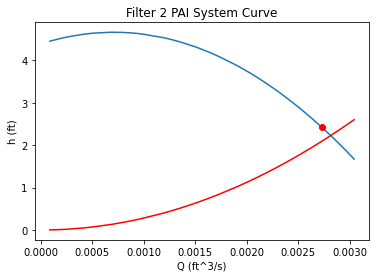

In [22]:
# second Cumins filter sys curve
plt.plot(Cuminq,Cuminp(Cuminq),'-')
Leqm=ktot2*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]

CFC2_x = Cuminq[find].astype(np.float)
CFC2_y = Cuminq[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 2 PAI System Curve")
labelP()
CFC2_x[0], CFC2_y[0]

### Filter 3

(0.002530886833333333, 1.6216103820139667)

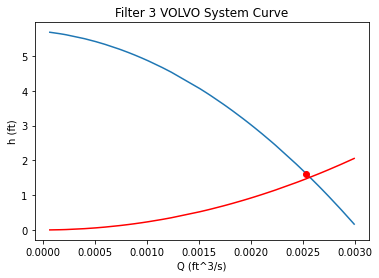

In [23]:
# Third Volv filter sys curve
plt.plot(Volvq,Volvp(Volvq),'-')
Leqm=ktot3*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
Volvq[find]

VFC3_x = Volvq[find].astype(np.float)
VFC3_y = Volvfind[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 3 VOLVO System Curve")
labelP()
VFC3_x[0], VFC3_y[0]

(0.0026878410555555552, 2.0193703356192394)

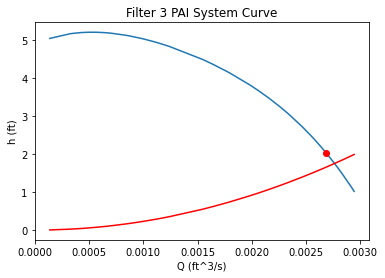

In [24]:
# third Pai filter sys curve
plt.plot(Paiq,Paip(Paiq),'-')
Leqm=ktot3*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]

PFC3_x = Paiq[find].astype(np.float)
PFC3_y = Paifind[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 3 PAI System Curve")
labelP()
PFC3_x[0], PFC3_y[0]

(0.0029134627499999995, 0.0029134627499999995)

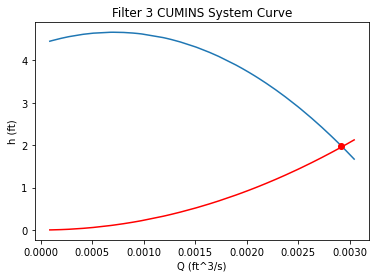

In [25]:
# third Cumins filter sys curve
plt.plot(Cuminq,Cuminp(Cuminq),'-')
Leqm=ktot3*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]

CFC3_x = Cuminq[find].astype(np.float)
CFC3_y = Cuminq[find].astype(np.float)
PFC_y = Paifind[find].astype(np.float)
plt.title("Filter 3 CUMINS System Curve")
labelP()
CFC3_x[0], CFC3_y[0]

### Filter 4

(0.002530886833333333, 1.6216103820139667)

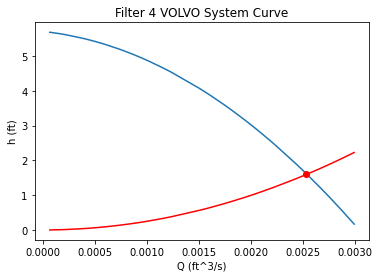

In [26]:
# forth Volv filter sys curve
plt.plot(Volvq,Volvp(Volvq),'-')
Leqm=ktot4*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
Volvq[find]
VFC4_x = Volvq[find].astype(np.float)
VFC4_y = Volvfind[find].astype(np.float)
plt.title("Filter 4 VOLVO System Curve")
labelP()
VFC4_x[0], VFC4_y[0]

(0.0026878410555555552, 2.0193703356192394)

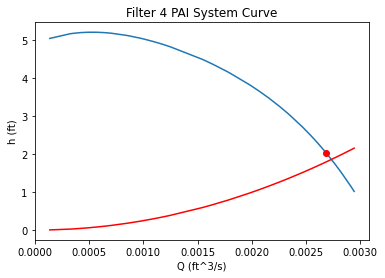

In [27]:
# fourth Pai filter sys curve
plt.plot(Paiq,Paip(Paiq),'-')
Leqm=ktot4*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]

PFC4_x = Paiq[find].astype(np.float)
PFC4_y = Paifind[find].astype(np.float)
plt.title("Filter 4 PAI System Curve")
labelP()
PFC4_x[0], PFC4_y[0]

(0.0028447952777777776, 0.0028447952777777776)

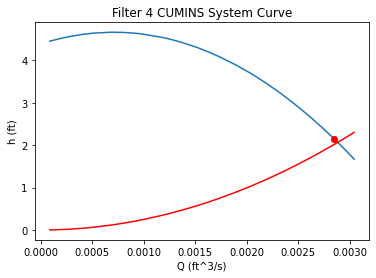

In [28]:
# fourth Cumins filter sys curve
plt.plot(Cuminq,Cuminp(Cuminq),'-')
Leqm=ktot4*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]
plt.title("Filter 4 CUMINS System Curve")
labelP()
CFC4_x = Cuminq[find].astype(np.float)
CFC4_y = Cuminq[find].astype(np.float)
CFC4_x[0], CFC4_y[0]

### Filter 5

(0.0024916482777777777, 1.735260646521997)

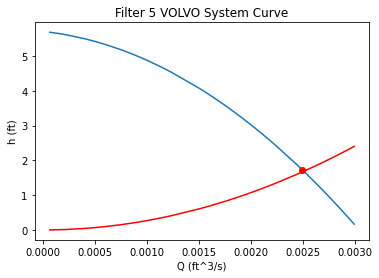

In [29]:
# fifth Volvo filter sys curve
plt.plot(Volvq,Volvp(Volvq),'-')
Leqm=ktot5*Volvdevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Volvdevdia**5))
syscurve=ktot*Volvq**2
plt.plot(Volvq,syscurve, 'r')
# finds intersect
Volvfind=Volvp(Volvq)
find=np.argwhere(np.diff(np.sign(Volvfind-syscurve))).flatten()
plt.plot(Volvq[find],Volvfind[find],'ro')
Volvq[find]
plt.title("Filter 5 VOLVO System Curve")
labelP()
VFC5_x = Volvq[find].astype(np.float)
VFC5_y = Volvfind[find].astype(np.float)
VFC5_x[0], VFC5_y[0]

(0.0026878410555555552, 2.0193703356192394)

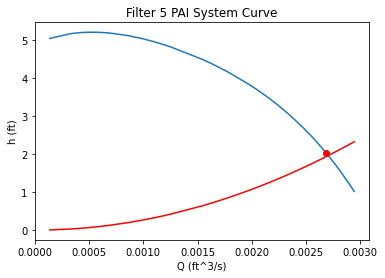

In [30]:
# fifth Pai filter sys curve
plt.plot(Paiq,Paip(Paiq),'-')
Leqm=ktot5*Paidevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Paidevdia**5))
syscurve=ktot*Paiq**2
plt.plot(Paiq,syscurve, 'r')
# finds intersect
Paifind=Paip(Paiq)
find=np.argwhere(np.diff(np.sign(Paifind-syscurve))).flatten()
plt.plot(Paiq[find],Paifind[find],'ro')
Paiq[find]
plt.title("Filter 5 PAI System Curve")
labelP()
PFC5_x = Paiq[find].astype(np.float)
PFC5_y = Paifind[find].astype(np.float)
PFC5_x[0], PFC5_y[0]

(0.0028153663611111108, 0.0028153663611111108)

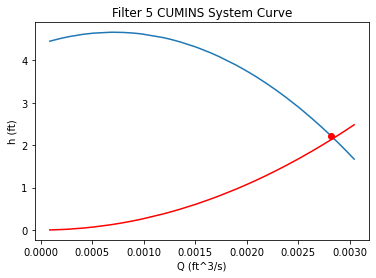

In [31]:
# fifth Cumins filter sys curve
plt.plot(Cuminq,Cuminp(Cuminq),'-')
Leqm=ktot5*Cumindevdia/f
Leqm=np.sum([Leqm])
Lentot=Leqm+fillentot
ktot=np.sum(8*f*Lentot/((3.14**2)*g*Cumindevdia**5))
syscurve=ktot*Cuminq**2
plt.plot(Cuminq,syscurve, 'r')
# finds intersect
Cuminfind=Cuminp(Cuminq)
find=np.argwhere(np.diff(np.sign(Cuminfind-syscurve))).flatten()
plt.plot(Cuminq[find],Cuminfind[find],'ro')
Cuminq[find]
plt.title("Filter 5 CUMINS System Curve")
labelP()
CFC5_x = Cuminq[find].astype(np.float)
CFC5_y = Cuminq[find].astype(np.float)
CFC5_x[0], CFC5_y[0]

## Part C

1. Qr is determined from Matlab code from power losses found in Part A

    $h_a(Q_{op}, K) = h_s(Q_{op}, K)$


2. Where the system curve and pump curve intersect is our operating point from Part B

    $Q_{R}(\mathcal{P}_{min}, \mathcal{P}_{max})$ 
    

3. Q BEP is the flowrate of the highest efficiency value found from Part B

    $Q_{BEP}$
    

4. Determine how far these points are from eachother and find which one has the smallest distance out of all the variables.

In [32]:
#Distances
def dist(bep,qo): #distance of the flow rates from operating and optimal from matlab code
    modela = (qo - bep)**2 + (Qr_A - bep)**2
    modelb = (qo - bep)**2 + (Qr_B - bep)**2
    modelc = (qo - bep)**2 + (Qr_C - bep)**2
    values = [modela,modelb,modelc]
    minval = min(values) #smallest distance of all the models
    
    models = ["Model A","Model B","Model C"]
    model = models[values.index(minval)] #pulls out name of same index of smallest distance
        
    return model,minval

pumps = ["Volvo","Pai","Cumin"]
pumpvals = [dist(q[VolvX],VPC_x[0]),dist(Paiqe[PaiX],PSC_x[0]),dist(Cuminqe[Cx],CPC_x[0])]

#filter values of the different pumps using the dist function to find the lowest value of all the models
f1 = [dist(q[VolvX],VFC_x[0]),dist(Paiqe[PaiX],PFC_x[0]),dist(Cuminqe[Cx],CFC1_x[0])] 
f2 = [dist(q[VolvX],VFC2_x[0]),dist(Paiqe[PaiX],PFC2_x[0]),dist(Cuminqe[Cx],CFC2_x[0])]
f3 = [dist(q[VolvX],VFC3_x[0]),dist(Paiqe[PaiX],PFC3_x[0]),dist(Cuminqe[Cx],CFC3_x[0])]
f4 = [dist(q[VolvX],VFC4_x[0]),dist(Paiqe[PaiX],PFC4_x[0]),dist(Cuminqe[Cx],CFC4_x[0])]
f5 = [dist(q[VolvX],VFC5_x[0]),dist(Paiqe[PaiX],PFC5_x[0]),dist(Cuminqe[Cx],CFC5_x[0])]
filters = [f1,f2,f3,f4,f5]   

def min_ind(filt): #finds the minimum and the index of all the different filter arrays + which pump it was
    min_val = min(filt)
    index = filt.index(min_val)
    name = pumps[index]
    return name, min_val

bestpump = min_ind(pumpvals)
print(f"The most efficient pump for the delivery system is {bestpump[0]} pump and {bestpump[1][0]}")

filtcombo = list(map(min_ind,filters)) #apply min_ind function to every item in the filters list

#add in cost + efficiency differences
price = np.concatenate([pr1,pr2,pr3,pr4,pr5]).ravel().tolist()
eff = np.concatenate([ef1,ef2,ef3,ef4,ef5]).ravel().tolist()

#This section of code gives us an ordered list of the most efficient combination for each filter (&which filter it is)
index = sorted(range(len(filtcombo)), key=filtcombo.__getitem__)#get indexes of ordered list of filters        
index = ["Filter 1" if i==0 else i for i in index]
index = ["Filter 2" if i==1 else i for i in index]
index = ["Filter 3" if i==2 else i for i in index]#replace ordered index with its corresponding filter number
index = ["Filter 4" if i==3 else i for i in index]
index = ["Filter 5" if i==4 else i for i in index]

def sortval(var):
    return var[1][1]
filtcombo.sort(key = sortval) #sorts the filter combinations in ascending order

The most efficient pump for the delivery system is Volvo pump and Model A


### For Filter System

In [33]:
#Top 3 options
print(f"Option 1: {filtcombo[0][0]} Pump, {filtcombo[0][1][0]}, {index[0]} \n\
Option 2: {filtcombo[1][0]} Pump, {filtcombo[1][1][0]}, {index[1]} (%{round(((filtcombo[0][1][1]-filtcombo[1][1][1])/filtcombo[0][1][1])*100,3)} change from option 1)\n\
Option 3: {filtcombo[2][0]} Pump, {filtcombo[2][1][0]}, {index[2]} (%{round(((filtcombo[0][1][1]-filtcombo[2][1][1])/filtcombo[0][1][1])*100,3)} change from option 1)\n\
Option 4: {filtcombo[3][0]} Pump, {filtcombo[3][1][0]}, {index[3]} (%{round(((filtcombo[0][1][1]-filtcombo[3][1][1])/filtcombo[0][1][1])*100,3)} change from option 1)\n\
Option 5: {filtcombo[4][0]} Pump, {filtcombo[4][1][0]}, {index[4]} (%{round(((filtcombo[0][1][1]-filtcombo[4][1][1])/filtcombo[0][1][1])*100,3)} change from option 1)\n\
      ")

Option 1: Volvo Pump, Model A, Filter 2 
Option 2: Volvo Pump, Model A, Filter 5 (%-0.921 change from option 1)
Option 3: Volvo Pump, Model A, Filter 1 (%-3.868 change from option 1)
Option 4: Volvo Pump, Model A, Filter 3 (%-3.868 change from option 1)
Option 5: Volvo Pump, Model A, Filter 4 (%-3.868 change from option 1)
      


In [34]:
#with prices
N = 7500 #trucks

orderedprice = []
orderedeff = []

for item in index:
    if item == "Filter 1":
        num = 0
    elif item == "Filter 2":
        num = 1
    elif item == "Filter 3":
        num = 2
    elif item == "Filter 4":
        num = 3
    elif item == "Filter 5":
        num = 4
            
    cost = price[num]*7500
    efficiency = eff[num]*100
    
    orderedprice.append(cost)
    orderedeff.append(efficiency)

print(f"Filter cost and associated efficiency:\n\
Option 1: ${orderedprice[0]} at {orderedeff[0]}% efficiency\n\
Option 2: ${orderedprice[1]} at {orderedeff[1]}% efficiency\n\
Option 3: ${orderedprice[2]} at {orderedeff[2]}% efficiency\n\
Option 4: ${orderedprice[3]} at {orderedeff[3]}% efficiency\n\
Option 5: ${orderedprice[4]} at {orderedeff[4]}% efficiency")


Filter cost and associated efficiency:
Option 1: $1500000.0 at 99.0% efficiency
Option 2: $1200000.0 at 92.0% efficiency
Option 3: $937500.0 at 85.0% efficiency
Option 4: $435000.0 at 65.0% efficiency
Option 5: $900000.0 at 87.0% efficiency
